In [3]:
import sys
sys.path.append('/home/arda/dinov2/')

from distillation.models.resnet_wrapper import ResNetWrapper

model = ResNetWrapper()

model.eval()

ResNetWrapper(
  (model): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), strid

In [17]:
# Load checkpoint and filter student weights
import torch
ckpt = torch.load('/home/arda/dinov2/distillation/logs/resnet50/distillation/dinoiser/checkpoints/last.ckpt')
student_state_dict = {k.replace('student.model.', ''): v for k, v in ckpt['state_dict'].items() if k.startswith('student.model.')}
student_state_dict.update({k.replace('loss_0.feature_matcher', 'conv3x3'): v for k, v in ckpt['state_dict'].items() if k.startswith('loss_0.feature_matcher')})

# Create and add 3x3 conv layer to the model
conv3x3 = torch.nn.Conv2d(2048, 1536, kernel_size=3, padding=1)
# Add conv3x3 layer to model
model.conv3x3 = conv3x3

# Modify forward method to include conv3x3 at the end
def forward_with_conv(self, x):
    output = self.model(x)
    # If output is a dictionary, extract the feature tensor
    if isinstance(output, dict):
        x = output['res5']  # or the appropriate key that contains the feature tensor
    else:
        x = output
    x = self.conv3x3(x)
    return x

model.forward = forward_with_conv.__get__(model)

model.forward = forward_with_conv.__get__(model)

# Load filtered state dict
model.load_state_dict(student_state_dict)
model.eval()

/home/arda/tmp/ipykernel_252239/1016968994.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load('/home/arda/dinov2/distillation/logs/resnet50/distillation/d

ResNetWrapper(
  (model): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), strid

In [19]:
from PIL import Image
import torchvision.transforms as transforms

# Load and preprocess the image
image_path = '/home/arda/dinov2/distillation/notebooks/images.jpeg'
image = Image.open(image_path)

# Define transforms
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Preprocess image and add batch dimension
img_tensor = transform(image).unsqueeze(0)

# Pass through model
with torch.no_grad():
    output = model(img_tensor)

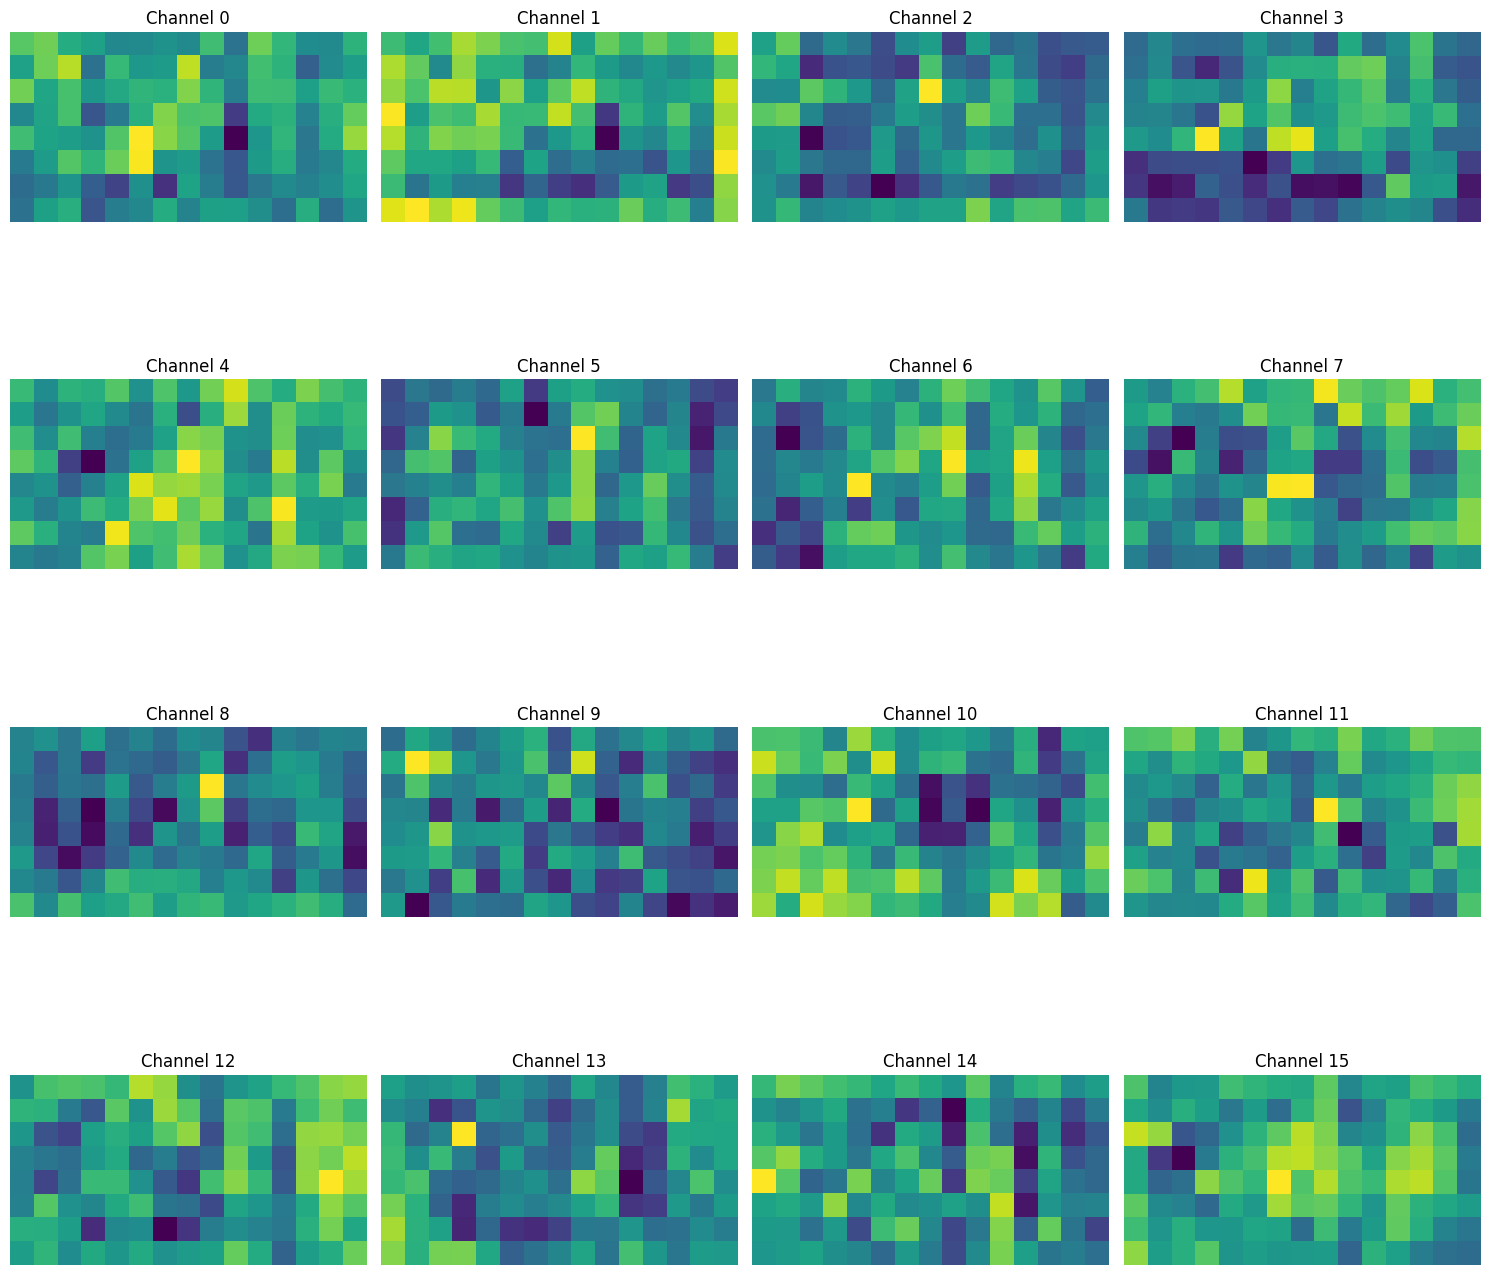

Output shape: torch.Size([1, 1536, 8, 15])
Number of channels: 1536
Spatial dimensions: 8x15


In [20]:
# Visualize the output feature maps
import matplotlib.pyplot as plt
import numpy as np

# Get feature maps from output
feature_maps = output.detach().cpu().numpy()[0]  # First batch item

# Calculate number of subplots needed
n_features = min(16, feature_maps.shape[0])  # Show first 16 channels
n_rows = int(np.ceil(np.sqrt(n_features)))
n_cols = n_rows

# Create subplot grid
plt.figure(figsize=(15, 15))
for i in range(n_features):
    plt.subplot(n_rows, n_cols, i + 1)
    
    # Normalize feature map for visualization
    feature_map = feature_maps[i]
    feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())
    
    plt.imshow(feature_map, cmap='viridis')
    plt.axis('off')
    plt.title(f'Channel {i}')

plt.tight_layout()
plt.show()

# Print shape information
print(f"Output shape: {output.shape}")
print(f"Number of channels: {output.shape[1]}")
print(f"Spatial dimensions: {output.shape[2]}x{output.shape[3]}")


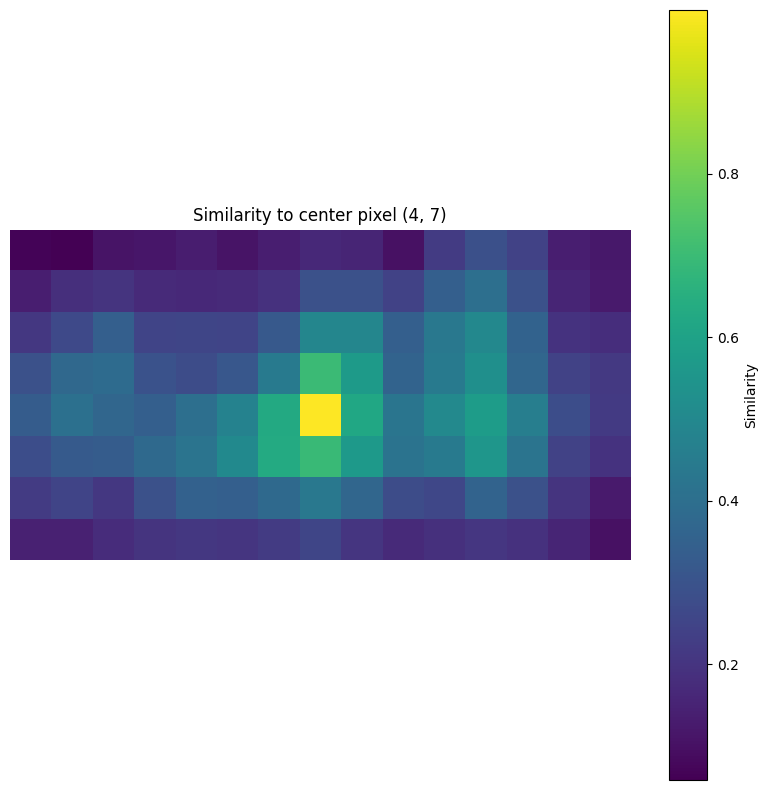

Min similarity: 0.059
Max similarity: 1.000
Mean similarity: 0.307


In [21]:
# Compute similarity matrix for visualization
B, C, H, W = output.shape
features = output.flatten(-2,-1)  # Flatten spatial dimensions
features = features/features.norm(dim=1, keepdim=True)  # Normalize features
similarity = torch.matmul(features.permute(0, 2, 1), features)[0]  # Take first batch

# Select center pixel and visualize its similarity to all other pixels
center_h, center_w = H//2, W//2
center_idx = center_h * W + center_w
similarity_map = similarity[center_idx].reshape(H, W)

plt.figure(figsize=(10, 10))
plt.imshow(similarity_map.cpu().numpy(), cmap='viridis')
plt.colorbar(label='Similarity')
plt.title(f'Similarity to center pixel ({center_h}, {center_w})')
plt.axis('off')
plt.show()

# Print similarity statistics
print(f"Min similarity: {similarity_map.min().item():.3f}")
print(f"Max similarity: {similarity_map.max().item():.3f}")
print(f"Mean similarity: {similarity_map.mean().item():.3f}")


In [26]:
student_keys = [key for key in ckpt['state_dict'].keys() if 'student' in key]

In [27]:
student_keys

['student.model.model.stem.conv1.weight',
 'student.model.model.stem.conv1.norm.weight',
 'student.model.model.stem.conv1.norm.bias',
 'student.model.model.stem.conv1.norm.running_mean',
 'student.model.model.stem.conv1.norm.running_var',
 'student.model.model.stem.conv1.norm.num_batches_tracked',
 'student.model.model.res2.0.shortcut.weight',
 'student.model.model.res2.0.shortcut.norm.weight',
 'student.model.model.res2.0.shortcut.norm.bias',
 'student.model.model.res2.0.shortcut.norm.running_mean',
 'student.model.model.res2.0.shortcut.norm.running_var',
 'student.model.model.res2.0.shortcut.norm.num_batches_tracked',
 'student.model.model.res2.0.conv1.weight',
 'student.model.model.res2.0.conv1.norm.weight',
 'student.model.model.res2.0.conv1.norm.bias',
 'student.model.model.res2.0.conv1.norm.running_mean',
 'student.model.model.res2.0.conv1.norm.running_var',
 'student.model.model.res2.0.conv1.norm.num_batches_tracked',
 'student.model.model.res2.0.conv2.weight',
 'student.model.m